# How CNNs and ViTs perceive similarities between categories

In this notebook, we show how to generate Class Similarity Matrices for different deep learning models (built with Keras and PyTorch) and WordNet path similarity measure. We also show how to compare a pair of CSMs with cosine similarity and two correlation measures. The last thing regards the manual examination of class neighborhood for an example model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from nltk.corpus import wordnet as wn
import nltk
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from keras.utils import to_categorical
from sklearn.metrics.pairwise import cosine_similarity

import scipy.stats as stats

## CSM generation and comparison 

Below, we create the Class Similarity Matrix based on example Keras model's weights for ImageNet classes. Step 1 in 'Experiments and experimental results'.

Without diagonal


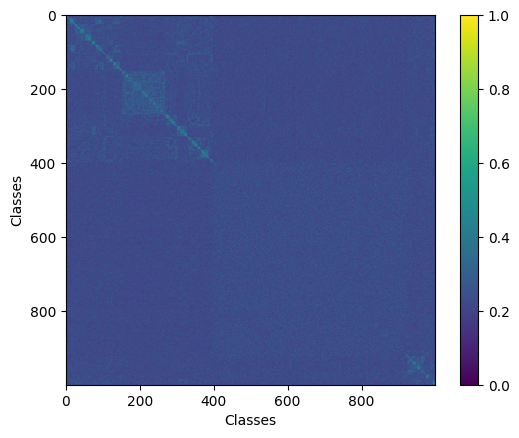

With diagonal


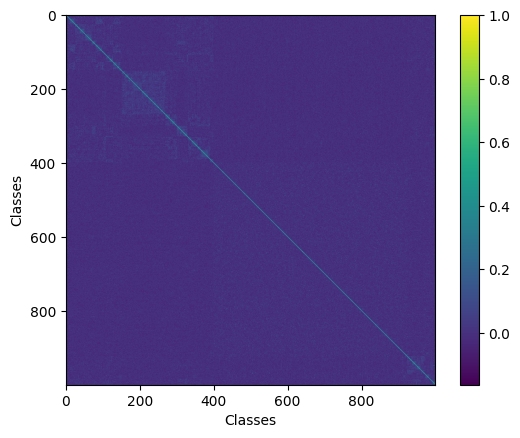

In [2]:
# example model from Keras Applications (other models are compatible):
from tensorflow.keras.applications import MobileNetV2

# see https://keras.io/api/applications/mobilenet/#mobilenetv2-function

# reading a model:
model = MobileNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

class_i = np.moveaxis(model.layers[-1].get_weights()[0], 0, -1)
class_j = np.moveaxis(model.layers[-1].get_weights()[0], 0, -1)

CSM_model1 = cosine_similarity(class_i, class_j)
CSM_model1_nodiagonal_raw = CSM_model1[~np.eye(CSM_model1.shape[0],dtype=bool)].reshape(CSM_model1.shape[0],-1)
CSM_model1_nodiagonal = (CSM_model1_nodiagonal_raw - np.min(CSM_model1_nodiagonal_raw)) / (np.max(CSM_model1_nodiagonal_raw) - np.min(CSM_model1_nodiagonal_raw))


# upper triangle of the CSM used to compute correlations between CSMs
mask = np.triu_indices(CSM_model1.shape[0], k=1)
CSM_model1_uppertriangle = CSM_model1[mask]
CSM_model1_uppertriangle = (CSM_model1_uppertriangle - np.min(CSM_model1_uppertriangle)) / (np.max(CSM_model1_uppertriangle) - np.min(CSM_model1_uppertriangle))

print("Without diagonal")
plt.imshow(CSM_model1_nodiagonal)
plt.ylabel('Classes')
plt.xlabel('Classes')
plt.colorbar()
plt.show()

print("With diagonal")
plt.imshow(CSM_model1)
plt.ylabel('Classes')
plt.xlabel('Classes')
plt.colorbar()
plt.show()

Below, we create the Class Similarity Matrix based on example PyTorch model's weights for ImageNet classes.

Without diagonal


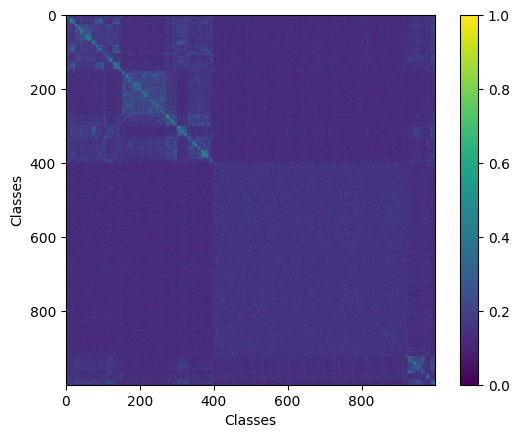

With diagonal


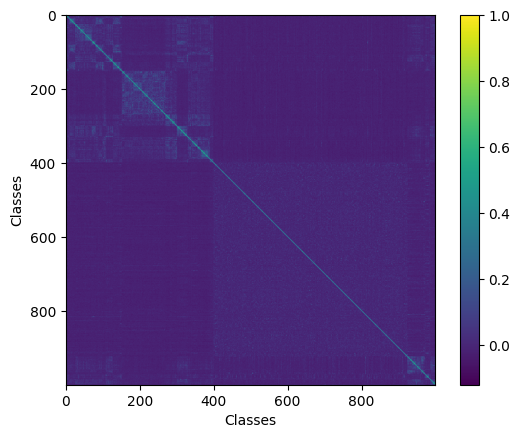

In [3]:
# see https://huggingface.co/microsoft/swinv2-tiny-patch4-window16-256

from transformers import AutoModelForImageClassification

name = "microsoft/swinv2-tiny-patch4-window16-256"
model = AutoModelForImageClassification.from_pretrained(name)

class_a = model.classifier.weight.detach().numpy()
class_b = model.classifier.weight.detach().numpy()

CSM_model2 = cosine_similarity(class_a, class_b)

CSM_model2_nodiagonal_raw = CSM_model2[~np.eye(CSM_model2.shape[0],dtype=bool)].reshape(CSM_model2.shape[0],-1)
CSM_model2_nodiagonal = (CSM_model2_nodiagonal_raw - np.min(CSM_model2_nodiagonal_raw)) / (np.max(CSM_model2_nodiagonal_raw) - np.min(CSM_model2_nodiagonal_raw))

# upper triangle of the CSM used to compute correlations between CSMs
mask = np.triu_indices(CSM_model2.shape[0], k=1)
CSM_model2_uppertriangle = CSM_model2[mask]
CSM_model2_uppertriangle = (CSM_model2_uppertriangle - np.min(CSM_model2_uppertriangle)) / (np.max(CSM_model2_uppertriangle) - np.min(CSM_model2_uppertriangle))

print("Without diagonal")
plt.imshow(CSM_model2_nodiagonal)
plt.ylabel('Classes')
plt.xlabel('Classes')
plt.colorbar()
plt.show()

print("With diagonal")
plt.imshow(CSM_model2)
plt.ylabel('Classes')
plt.xlabel('Classes')
plt.colorbar()
plt.show()

Below, we create the Class Similarity Matrix based on WordNet path similarity for ImageNet classes. Step 1 in 'Experiments and experimental results'.

In [4]:
offsets = []
imagenet_classes = decode_predictions(to_categorical(np.expand_dims(np.array(range(1000)), axis=-1), num_classes=1000), top=1)

for c in imagenet_classes:
    offsets.append(int(c[0][0].split('n')[1]))
    
similarity_wordnet = np.zeros((1000, 1000))

for i in range(1000):
    for j in range(1000):
        n = wn.synset_from_pos_and_offset('n', int(offsets[i]))
        m = wn.synset_from_pos_and_offset('n', int(offsets[j]))
        similarity_wordnet[i][j] = n.path_similarity(m)
# similarity_wordnet - Class Similarity Matrix generated with WordNet path similarity measure

Without diagonal


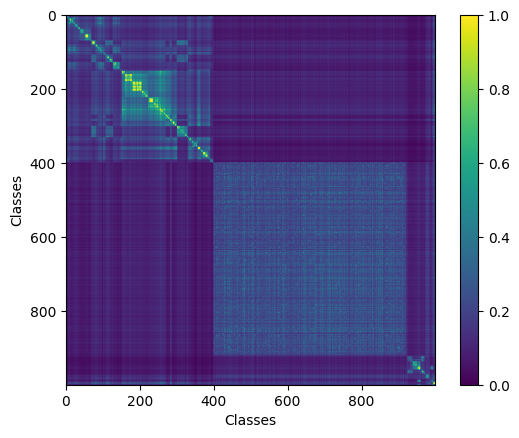

With diagonal


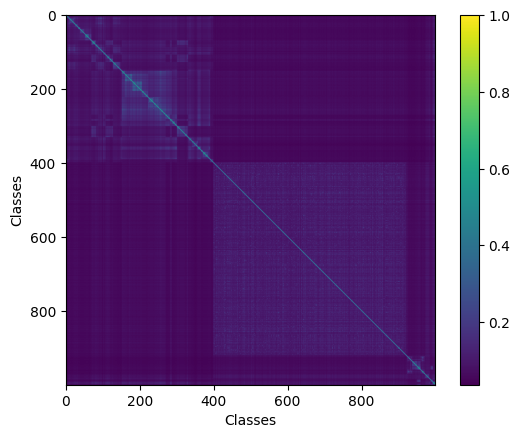

In [5]:
CSM_wordnet = similarity_wordnet

CSM_wordnet_nodiagonal = similarity_wordnet[~np.eye(similarity_wordnet.shape[0],dtype=bool)].reshape(similarity_wordnet.shape[0],-1)
CSM_wordnet_nodiagonal = (CSM_wordnet_nodiagonal - np.min(CSM_wordnet_nodiagonal)) / (np.max(CSM_wordnet_nodiagonal) - np.min(CSM_wordnet_nodiagonal))

# upper triangle of the CSM used to compute correlations between CSMs
mask = np.triu_indices(CSM_wordnet.shape[0], k=1)
CSM_wordnet_uppertriangle = CSM_wordnet[mask]
CSM_wordnet_uppertriangle = (CSM_wordnet_uppertriangle - np.min(CSM_wordnet_uppertriangle)) / (np.max(CSM_wordnet_uppertriangle) - np.min(CSM_wordnet_uppertriangle))

print("Without diagonal")
plt.imshow(CSM_wordnet_nodiagonal)
plt.ylabel('Classes')
plt.xlabel('Classes')
plt.colorbar()
plt.show()

print("With diagonal")
plt.imshow(CSM_wordnet)
plt.ylabel('Classes')
plt.xlabel('Classes')
plt.colorbar()
plt.show()

Measuring similarities/correlation between CSMs. Used to generate 3 SSAD variants - Semantic Similarity Alignment Degree

Step 2, 3 and 5 in 'Experiments and experimental results'.

In [6]:
# cosine similarity:
nom = np.sum(CSM_wordnet_nodiagonal*CSM_model2_nodiagonal)
denom = np.sqrt((np.sum(CSM_wordnet_nodiagonal ** 2))) * np.sqrt((np.sum(CSM_model2_nodiagonal ** 2)))
CS = nom/denom

#correlations
spearman_corr = stats.spearmanr(CSM_model2_uppertriangle, CSM_wordnet_uppertriangle)[0]
kendallcorr = stats.kendalltau(CSM_model2_uppertriangle, CSM_wordnet_uppertriangle)[0]

print(f"swinv2-tiny-patch4-window16-256 - WordNet path")
print(f"Cosine Similarity: {CS}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall Correlation: {kendallcorr}")

swinv2-tiny-patch4-window16-256 - WordNet path
Cosine Similarity: 0.852219473817032
Spearman Correlation: 0.3022964080455085
Kendall Correlation: 0.21174004583135825


In [7]:
# cosine similarity:
nom = np.sum(CSM_wordnet_nodiagonal*CSM_model1_nodiagonal)
denom = np.sqrt((np.sum(CSM_wordnet_nodiagonal ** 2))) * np.sqrt((np.sum(CSM_model1_nodiagonal ** 2)))
CS = nom/denom

#correlations
spearman_corr = stats.spearmanr(CSM_model1_uppertriangle, CSM_wordnet_uppertriangle)[0]
kendallcorr = stats.kendalltau(CSM_model1_uppertriangle, CSM_wordnet_uppertriangle)[0]

print(f"MobileNetV2 - WordNet path")
print(f"Cosine Similarity: {CS}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall Correlation: {kendallcorr}")

MobileNetV2 - WordNet path
Cosine Similarity: 0.821506543749552
Spearman Correlation: 0.10802516396203636
Kendall Correlation: 0.07471187790052376


In [8]:
# cosine similarity:

nom = np.sum(CSM_model2_nodiagonal_raw*CSM_model1_nodiagonal_raw)
denom = np.sqrt((np.sum(CSM_model2_nodiagonal_raw ** 2))) * np.sqrt((np.sum(CSM_model1_nodiagonal_raw ** 2)))
CS = nom/denom

#correlations
spearman_corr = stats.spearmanr(CSM_model1_uppertriangle, CSM_model2_uppertriangle)[0]
kendallcorr = stats.kendalltau(CSM_model1_uppertriangle, CSM_model2_uppertriangle)[0]

print(f"MobileNetV2 - swinv2-tiny-patch4-window16-256")
print(f"Cosine Similarity: {CS}")
print(f"Spearman Correlation: {spearman_corr}")
print(f"Kendall Correlation: {kendallcorr}")

MobileNetV2 - swinv2-tiny-patch4-window16-256
Cosine Similarity: 0.5098748803138733
Spearman Correlation: 0.31987453592415604
Kendall Correlation: 0.2190488668095211


## Manual analysis of class neighborhood

Step 4 in 'Experiments and experimental results'.

Printing most similar classes to all 1k ImageNet classes can be done with:

In [9]:
def print_top_neighbors(CSM, first_classes, num_neighbors):
    """ Function can be used to print the neighborhood of first classes from the class list of a given network. 
    Parameters:
    CSM - Class Similarity Matrix of a network to be examined
    first_classes - number of the first classes from the list of all classess (for ImageNet 1000 means all classes)
    num_neighbors - number of neighborst to be print for each class
    """
    sorted_CSM = np.argsort(-CSM, axis=1)[:, 1:num_neighbors+1]
    print(f"Top {num_neighbors} most similar classes for each class (for first {first_classes} ImageNet classes)")
    for i in range(first_classes):
        print("==============================================")
        print(decode_predictions(to_categorical([i], num_classes=1000), top=1)[0][0][1])
        print(decode_predictions(to_categorical(sorted_CSM[i], num_classes=1000), top=1))
        print("==============================================")

We present the example for swinv2-tiny-patch4-window16-256 first 5 classes and 10 neighbors:

In [10]:
print_top_neighbors(CSM=CSM_model2, first_classes=5, num_neighbors=10)

Top 10 most similar classes for each class (for first 5 ImageNet classes)
tench
[[('n02514041', 'barracouta', 1.0)], [('n02536864', 'coho', 1.0)], [('n02640242', 'sturgeon', 1.0)], [('n02641379', 'gar', 1.0)], [('n01443537', 'goldfish', 1.0)], [('n02526121', 'eel', 1.0)], [('n02606052', 'rock_beauty', 1.0)], [('n01632777', 'axolotl', 1.0)], [('n01873310', 'platypus', 1.0)], [('n02074367', 'dugong', 1.0)]]
goldfish
[[('n01632777', 'axolotl', 1.0)], [('n02607072', 'anemone_fish', 1.0)], [('n01440764', 'tench', 1.0)], [('n02606052', 'rock_beauty', 1.0)], [('n02007558', 'flamingo', 1.0)], [('n02655020', 'puffer', 1.0)], [('n01631663', 'eft', 1.0)], [('n02317335', 'starfish', 1.0)], [('n01910747', 'jellyfish', 1.0)], [('n07747607', 'orange', 1.0)]]
great_white_shark
[[('n01491361', 'tiger_shark', 1.0)], [('n01494475', 'hammerhead', 1.0)], [('n02066245', 'grey_whale', 1.0)], [('n02074367', 'dugong', 1.0)], [('n02071294', 'killer_whale', 1.0)], [('n01498041', 'stingray', 1.0)], [('n10565667',

**Closest Neighbor Pair Ranking (CNPR)**

Below, we provide an implementation of function that can be used to print the most similar pairs of classes (overall):

In [11]:
def print_most_similar_pairs(CSM, top_pairs):
    """ Function can be used to print the pairs of the most similar classes of a given network. 
    Parameters:
    CSM - Class Similarity Matrix of a network to be examined
    top_pairs - number of the first class pairs (the most similar ones) from the list of all classess to be printed
    """
    GT_tab = np.argsort(-np.sort(CSM, axis=1)[:, -2])
    MS_tab_per_GT = np.argsort(CSM[GT_tab], axis=1)[:, -2]
    print("Most similar pairs")
    for i in range(top_pairs):
        a = decode_predictions(to_categorical(np.expand_dims(GT_tab[i], axis=0), num_classes=1000), top=1)[0][0][1]
        b = decode_predictions(to_categorical(np.expand_dims(MS_tab_per_GT[i], axis=0), num_classes=1000), top=1)[0][0][1]
        print(f"{i + 1}. {a} - {b}")

In [13]:
print_most_similar_pairs(CSM=CSM_model2, top_pairs=10)

Most similar pairs
1. missile - projectile
2. projectile - missile
3. partridge - ruffed_grouse
4. ruffed_grouse - partridge
5. sidewinder - horned_viper
6. horned_viper - sidewinder
7. green_lizard - American_chameleon
8. American_chameleon - green_lizard
9. garden_spider - black_and_gold_garden_spider
10. black_and_gold_garden_spider - garden_spider
